In [2]:
import yfinance as yf
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [3]:
dji_raw = yf.download("DJI", start="2021-01-01", end="2022-07-30")['Close']
dji = dji_raw.reset_index()
dji['month'] = dji['Date'].dt.month
dji['year'] = dji['Date'].dt.year
dji['delta_Close'] = dji['Close'].diff()
dji.head()

[*********************100%***********************]  1 of 1 completed


,Date,Close,month,year,delta_Close
0,2020-12-31,30606.500000,12,2020,NaN
1,2021-01-04,30223.900391,1,2021,-382.599609
2,2021-01-05,30391.599609,1,2021,167.699219
3,2021-01-06,30829.400391,1,2021,437.800781
4,2021-01-07,31041.099609,1,2021,211.699219


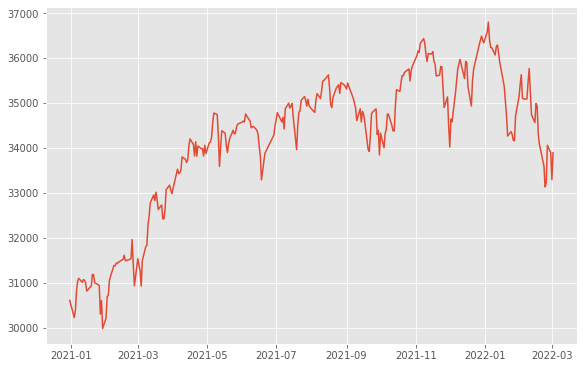

In [4]:
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 5))
    ax.plot(dji['Date'], dji['Close'])

ACF

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


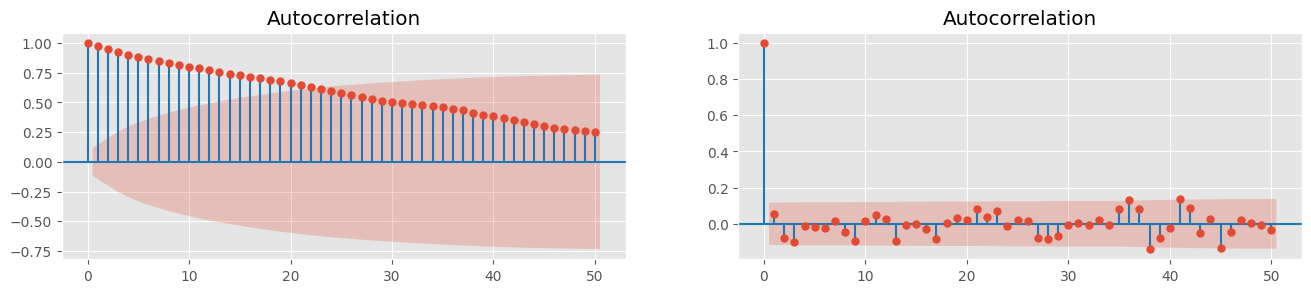

In [11]:
dji_acf = acf(dji['Close'], nlags=50)

with plt.style.context('ggplot'):
    fig, axes = plt.subplots(1, 2, figsize=(16,3), dpi=100)
    plot_acf(dji['Close'], lags=50, ax=axes[0])
    plot_acf(dji['delta_Close'].dropna(), lags=50, ax=axes[1]) # Diffs are stationary

### Federal Fund Rate

In [12]:
fed_funds = pdr.get_data_fred('FEDFUNDS').reset_index()
fed_funds['delta_rate'] = fed_funds['FEDFUNDS'].diff()
fed_funds['month'] = fed_funds['DATE'].dt.month
fed_funds['year'] = fed_funds['DATE'].dt.year

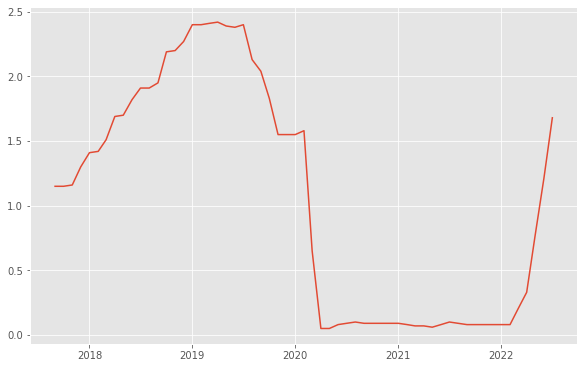

In [13]:
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 5))
    ax.plot(fed_funds['DATE'], fed_funds['FEDFUNDS'])

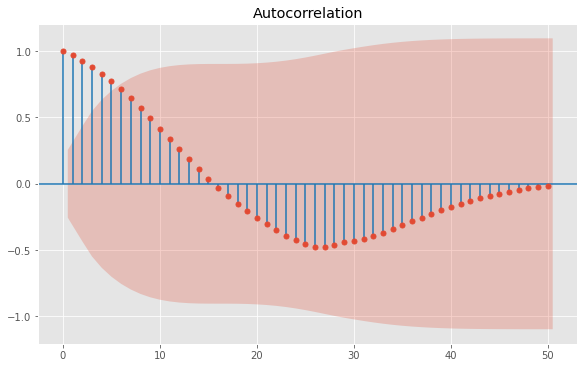

In [14]:
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 5))
    plot_acf(fed_funds['FEDFUNDS'], lags=50, ax=ax) # Stationary? We see a quick decline

### Regression

In [ ]:
# ARIMA: https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

In [15]:
agg_fed_rate = fed_funds.groupby(by=['year', 'month']).agg({'delta_rate': 'sum'}) # i.e. monthly changes in fed fund rate
fin_df = dji.join(agg_fed_rate, on=['year', 'month']).assign(delta_rate = lambda x: x['delta_rate'] * 100)
fin_df.head()

,Date,Close,month,year,delta_Close,delta_rate
0,2020-12-31,30606.500000,12,2020,NaN,0.0
1,2021-01-04,30223.900391,1,2021,-382.599609,0.0
2,2021-01-05,30391.599609,1,2021,167.699219,0.0
3,2021-01-06,30829.400391,1,2021,437.800781,0.0
4,2021-01-07,31041.099609,1,2021,211.699219,0.0


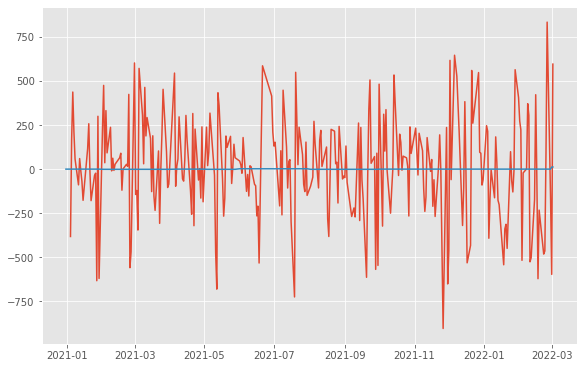

In [16]:
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 5))
    ax.plot(fin_df['Date'], fin_df['delta_Close'])
    ax.plot(fin_df['Date'], fin_df['delta_rate'])

In [17]:
model = ARIMA(fin_df['delta_Close'], exog=fin_df['delta_rate'],order=(1, 0, 1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            delta_Close   No. Observations:                  281
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1981.349
Date:                Fri, 26 Aug 2022   AIC                           3972.697
Time:                        16:22:22   BIC                           3990.889
Sample:                             0   HQIC                          3979.993
                                - 281                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.7086     19.070      0.614      0.539     -25.667      49.084
delta_rate    -3.2136      8.061     -0.399      0.690     -19.012      12.585
ar.L1         -0.2505      0.705     -0.355      0.7

### TODO: 
 - change diffs to returns see: https://medium.com/@dreamferus/visualizing-stock-market-patterns-using-data-in-python-ece047a93387 or Tsay for more thorough analysis 